<a href="https://colab.research.google.com/github/hamsungmin/DataTrainAnalysis/blob/main/project_week12_YOLO%EA%B0%9D%EC%B2%B4%EC%9D%B8%EC%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1-1. 욜로 객체인식을 기반으로 한 회의실 상태 출력**

<aside>

**진행 프로세스**

- 이 작업은 YOLO로 회의실 상태를 실시간으로 파악하여 이모지와 간결한 텍스트로 즉각적인 공간 활용 의사결정을 돕는 데 의의가 있습니다.
 또한, 수집된 데이터를 바탕으로 장기적인 공간 관리 전략을 수립하는 기초 자료로 활용될 수 있습니다.  (이미지폴더: 회의실)
- YOLO로 회의실 이미지를 분석하여 사람 수 기반 상태(비어있음/소규모/혼잡)를 한글+이모지로 출력 (출력 예시는 참고용이고 상태 기준과 표현 방식은 자유롭게 설정)
- 객체에 박스화된 시각화 결과 이미지 저장
</aside>

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.1 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# YOLOv8 모델 로드 (원하는 모델 버전으로 변경 가능)
model = YOLO('yolov8n.pt') # 'yolov8n.pt' 대신 'yolov8m.pt', 'yolov8l.pt' 등을 사용할 수 있습니다.

# 회의실 이미지가 있는 폴더 경로
image_folder = '회의실'

# 폴더가 없으면 생성 (이미지를 미리 넣어두셔야 합니다.)
if not os.path.exists(image_folder):
    os.makedirs(image_folder)
    print(f"'{image_folder}' 폴더를 생성했습니다. 이 폴더에 회의실 이미지를 넣어주세요.")
else:
    print(f"'{image_folder}' 폴더가 이미 있습니다.")

# 결과를 저장할 폴더 생성
output_folder = '회의실_결과'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"'{output_folder}' 폴더를 생성했습니다.")

'회의실' 폴더가 이미 있습니다.



- 사람 수 0명: 비어있음 👻
- 사람 수 1~3명: 소규모 👥
- 사람 수 4명 이상: 혼잡 💢

In [ ]:
person_class_id = 0
chair_class_id = 56  # COCO 데이터셋 기준 의자 클래스 ID
table_class_id = 57 # COCO 데이터셋 기준 식탁 클래스 ID (dining table) 또는 60 (couch) 등을 확인해보세요

# 상태 판별 함수
def get_room_status(person_count):
    if person_count == 0:
        return "비어있음 👻"
    elif 1 <= person_count <= 3:
        return "소규모 👥"
    else:
        return "혼잡 💢"

# 이미지 파일 목록 가져오기
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]

if not image_files:
    print(f"'{image_folder}' 폴더에 이미지 파일이 없습니다.")
else:
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        print(f"\n이미지 분석 중: {image_file}")

        # 이미지 로드
        img = cv2.imread(image_path)
        if img is None:
            print(f"이미지 파일을 읽을 수 없습니다: {image_file}")
            continue

        # 객체 감지 수행
        results = model(img)

        # 사람, 의자, 테이블 객체 필터링 및 개수 세기
        person_count = 0
        person_boxes = []
        chair_boxes = []
        table_boxes = []

        for r in results:
            for i in range(len(r.boxes)):
                cls = int(r.boxes.cls[i])
                box = r.boxes.xyxy[i].cpu().numpy() # 바운딩 박스 좌표 저장

                if cls == person_class_id:
                    person_count += 1
                    person_boxes.append(box)
                elif cls == chair_class_id:
                    chair_boxes.append(box)
                elif cls == table_class_id:
                    table_boxes.append(box)


        # 회의실 상태 판별 및 출력
        status = get_room_status(person_count)
        print(f"회의실 상태: {status} ({person_count}명 감지)")
        print(f"감지된 의자 수: {len(chair_boxes)}, 감지된 테이블 수: {len(table_boxes)}")


        # 시각화 결과 생성 및 저장
        # 원본 이미지를 복사하여 그 위에 그립니다.
        img_annotated = img.copy()

        # 사람 박스 (초록색)
        person_color = (0, 255, 0)
        for box in person_boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_annotated, (x1, y1), (x2, y2), person_color, 2)
            # 필요하다면 라벨 추가
            # cv2.putText(img_annotated, 'person', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, person_color, 2)

        # 의자 박스 (빨간색)
        chair_color = (0, 0, 255)
        for box in chair_boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_annotated, (x1, y1), (x2, y2), chair_color, 2)
            # 필요하다면 라벨 추가
            # cv2.putText(img_annotated, 'chair', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, chair_color, 2)

        # 테이블 박스 (파란색)
        table_color = (255, 0, 0)
        for box in table_boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_annotated, (x1, y1), (x2, y2), table_color, 2)
            # 필요하다면 라벨 추가
            # cv2.putText(img_annotated, 'table', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, table_color, 2)


        # 결과 이미지 파일명 생성
        output_filename = f"result_{os.path.splitext(image_file)[0]}.jpg"
        output_path = os.path.join(output_folder, output_filename)

        # 시각화 결과 이미지 저장
        cv2.imwrite(output_path, img_annotated)
        print(f"시각화 결과 저장됨: {output_path}")



이미지 분석 중: No4_meeting_room.jpg

0: 448x640 7 persons, 1 cup, 5 chairs, 1 tv, 1 laptop, 1 keyboard, 187.9ms
Speed: 3.4ms preprocess, 187.9ms inference, 5.0ms postprocess per image at shape (1, 3, 448, 640)
회의실 상태: 혼잡 💢 (7명 감지)
감지된 의자 수: 5, 감지된 테이블 수: 0
시각화 결과 저장됨: 회의실_결과/result_No4_meeting_room.jpg

이미지 분석 중: No2_meeting_room.jpg

0: 480x640 9 chairs, 1 dining table, 187.7ms
Speed: 5.0ms preprocess, 187.7ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)
회의실 상태: 비어있음 👻 (0명 감지)
감지된 의자 수: 9, 감지된 테이블 수: 0
시각화 결과 저장됨: 회의실_결과/result_No2_meeting_room.jpg

이미지 분석 중: No3_meeting_room.jpg

0: 448x640 3 persons, 3 chairs, 1 dining table, 166.2ms
Speed: 5.8ms preprocess, 166.2ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)
회의실 상태: 소규모 👥 (3명 감지)
감지된 의자 수: 3, 감지된 테이블 수: 0
시각화 결과 저장됨: 회의실_결과/result_No3_meeting_room.jpg

이미지 분석 중: No1_meeting_room.jpg

0: 480x640 6 chairs, 1 dining table, 1 tv, 184.5ms
Speed: 4.2ms preprocess, 184.5ms inference, 2.1ms postprocess 

**1-2. 욜로객체인식 & GPT프롬프트 엔지니어링을 결합한 보고서 자동화**

<aside>

**진행 프로세스**

- 사무실을 운영하는 데 있어 **사무실 공간 활용 효율성**은 중요한 문제입니다. 직원이 1000명 이상인 대기업 사무실을 상상해 보세요. 회의실, 휴게 공간, 개인 작업 공간 등 다양한 공간이 있습니다. 이 공간들이 효율적으로 사용되고 있는지 분석하고 최적화하는 일은 매우 복잡합니다.
- GPT는 단순한 규칙을 넘어 **'패턴'과 '경향성'을 분석**하고 **'상황'을 판단할수 있습니다.**
    - **YOLO**: 각 공간에 있는 사람 수, 사용 중인 장비(PC, 모니터 등)를 실시간으로 파악합니다.
    - **사무실 관리 시스템**: 직원 출퇴근 기록, 특정 공간 사용 시간 등을 연동합니다.
    - **캘린더**: 회의실 예약 정보 등을 가져옵니다.
    - **GPT의 역할 (분석가)**: GPT는 이 모든 데이터를 종합하여 다음과 같은 심층적인 분석을 수행합니다. (추후 데이터셋이 충분히 확보되었을때 분석가능)
        - "오전 10시부터 12시까지 B 회의실은 매일 예약되어 있지만, YOLO 분석 결과 30분 이상 비어있는 시간이 많습니다. 이는 예약 시스템이 제대로 활용되지 않고 있음을 시사합니다."
        - "점심시간 이후 C 휴게 공간 사용률이 급증합니다. 반면, D 휴게 공간은 거의 사용되지 않습니다. C 공간에 추가 편의 시설을 배치하고, D 공간은 개인 업무 공간으로 전환하는 것을 고려할 수 있습니다."
        - "금요일 오후에는 개인 업무 공간의 사용률이 현저히 낮고, 일부 직원들이 회의실에서 개별적으로 작업하는 경향이 있습니다. 이는 유연 근무제 도입이나 협업 공간 확충에 대한 요구가 반영된 현상일 수 있습니다."
- 다음과 같은 회의실 예약상태를 가상으로 작성한후 회의실 예약현황 & 욜로객체탐지 & GPT프롬프트 엔지니어링을 활용한 보고서 자동화를 계획합니다.
    - **YOLO 모델로 회의실 이미지를 분석**하여 사람 수, 객체 감지 결과를 정리하고 예약 현황과 함께 구조
    - **GPT 1단계**에서는 YOLO 감지와 예약 데이터의 불일치 사례를 분석·추론하고, **GPT 2단계**에서는 이 분석을 바탕으로 경영진용 보고서를 **마크다운 형식**으로 출력
    - 스트림릿으로 변경한 UI를 설계합니다.
        
      
        

</aside>

In [ ]:
# 회의실 예약 상태 (예시)
reservation_data = {
    "회의실1": {"status": "reserved"},
    "회의실2": {"status": "available"},
    "회의실3": {"status": "reserved"},
    "회의실4": {"status": "available"},
    "회의실5": {"status": "available"}
}

print(reservation_data)

{'회의실1': {'status': 'reserved'}, '회의실2': {'status': 'available'}, '회의실3': {'status': 'reserved'}, '회의실4': {'status': 'available'}, '회의실5': {'status': 'available'}}


In [ ]:
# 1. YOLO 분석 결과를 담을 딕셔너리 초기화
yolo_results = {}

# 2. YOLO 분석 결과 추출 및 저장 (이전 코드 참조)
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    img = cv2.imread(image_path)
    if img is None:
        print(f"이미지 파일을 읽을 수 없습니다: {image_file}")
        continue

    results = model(img)

    person_count = 0
    chair_count = 0
    table_count = 0

    for r in results:
        for i in range(len(r.boxes)):
            cls = int(r.boxes.cls[i])
            if cls == person_class_id:
                person_count += 1
            elif cls == chair_class_id:
                chair_count += 1
            elif cls == table_class_id:
                table_count += 1

    # 이미지 파일명에서 확장자 제거하고 회의실 이름으로 사용
    room_name = os.path.splitext(image_file)[0].replace('_meeting_room', '').replace('No', '회의실')

    yolo_results[room_name] = {
        "person_count": person_count,
        "chair_count": chair_count,
        "table_count": table_count
    }

# 3. YOLO 감지 결과와 예약 데이터를 결합
combined_data = {}
for room_name in reservation_data.keys():
    combined_data[room_name] = {
        "reservation_status": reservation_data[room_name]["status"],
        "yolo_detection": yolo_results.get(room_name, {"person_count": 0, "chair_count": 0, "table_count": 0}) # YOLO 결과가 없는 경우 기본값 설정
    }

# 4. 결합된 데이터 출력
print("결합된 회의실 데이터:")
print(combined_data)


0: 448x640 7 persons, 1 cup, 5 chairs, 1 tv, 1 laptop, 1 keyboard, 182.3ms
Speed: 4.0ms preprocess, 182.3ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 9 chairs, 1 dining table, 184.3ms
Speed: 5.5ms preprocess, 184.3ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 3 persons, 3 chairs, 1 dining table, 165.1ms
Speed: 4.1ms preprocess, 165.1ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 6 chairs, 1 dining table, 1 tv, 184.5ms
Speed: 4.2ms preprocess, 184.5ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 3 persons, 11 chairs, 1 dining table, 1 tv, 139.6ms
Speed: 5.4ms preprocess, 139.6ms inference, 3.1ms postprocess per image at shape (1, 3, 352, 640)
결합된 회의실 데이터:
{'회의실1': {'reservation_status': 'reserved', 'yolo_detection': {'person_count': 0, 'chair_count': 6, 'table_count': 0}}, '회의실2': {'reservation_status': 'available', 'yolo_detection': {'person_count': 0, 

In [ ]:
# 분석 결과를 저장할 딕셔너리 (또는 combined_data에 직접 추가)
analysis_results = {}

for room_name, data in combined_data.items():
    reservation_status = data["reservation_status"]
    person_count = data["yolo_detection"]["person_count"]

    discrepancy = None
    inferred_cause = None

    # 불일치 식별 및 원인 추론 로직
    if reservation_status == "reserved" and person_count == 0:
        discrepancy = "예약됨 상태이나 사람이 없음"
        inferred_cause = "예약 후 미사용 또는 예약 시스템 오류 가능성"
    elif reservation_status == "reserved" and person_count > 0 and person_count < data["yolo_detection"]["chair_count"]:
         # 예약되었고 사람이 있지만, 감지된 의자 수보다 사람이 적은 경우
        discrepancy = "예약됨 상태이며 사람이 있지만, 예상보다 적은 인원 사용"
        inferred_cause = "예정된 회의 인원 변경 또는 부분적인 공간 활용 가능성"
    elif reservation_status == "available" and person_count > 0:
        discrepancy = "예약 가능 상태이나 사람이 있음"
        inferred_cause = "갑작스러운 비공식 회의 또는 개인적인 공간 활용 가능성"
    # 추가적인 불일치 조건 및 원인 추론 로직을 여기에 추가할 수 있습니다.

    # 분석 결과 저장
    combined_data[room_name]["analysis"] = {
        "discrepancy": discrepancy,
        "inferred_cause": inferred_cause
    }

# 분석 결과 출력하여 확인
print("\n불일치 분석 결과가 추가된 결합 데이터:")
print(combined_data)


불일치 분석 결과가 추가된 결합 데이터:
{'회의실1': {'reservation_status': 'reserved', 'yolo_detection': {'person_count': 0, 'chair_count': 6, 'table_count': 0}, 'analysis': {'discrepancy': '예약됨 상태이나 사람이 없음', 'inferred_cause': '예약 후 미사용 또는 예약 시스템 오류 가능성'}}, '회의실2': {'reservation_status': 'available', 'yolo_detection': {'person_count': 0, 'chair_count': 9, 'table_count': 0}, 'analysis': {'discrepancy': None, 'inferred_cause': None}}, '회의실3': {'reservation_status': 'reserved', 'yolo_detection': {'person_count': 3, 'chair_count': 3, 'table_count': 0}, 'analysis': {'discrepancy': None, 'inferred_cause': None}}, '회의실4': {'reservation_status': 'available', 'yolo_detection': {'person_count': 7, 'chair_count': 5, 'table_count': 0}, 'analysis': {'discrepancy': '예약 가능 상태이나 사람이 있음', 'inferred_cause': '갑작스러운 비공식 회의 또는 개인적인 공간 활용 가능성'}}, '회의실5': {'reservation_status': 'available', 'yolo_detection': {'person_count': 3, 'chair_count': 11, 'table_count': 0}, 'analysis': {'discrepancy': '예약 가능 상태이나 사람이 있음', 'inferred_cau

In [ ]:
# 1. Create an empty string variable to store the markdown report content.
markdown_report = ""

# 2. Add a main heading for the report.
markdown_report += "# 회의실 공간 활용 분석 보고서\n\n"

# 3. Iterate through the combined_data dictionary.
for room_name, data in combined_data.items():
    # 4. For each meeting room, add a subheading.
    markdown_report += f"## {room_name}\n\n"

    # 5. Include the information using markdown formatting.
    markdown_report += f"**예약 상태:** {data['reservation_status']}\n\n"
    markdown_report += "**YOLO 감지 결과:**\n"
    markdown_report += f"- 감지된 사람 수: {data['yolo_detection']['person_count']}명\n"
    markdown_report += f"- 감지된 의자 수: {data['yolo_detection']['chair_count']}개\n"
    markdown_report += f"- 감지된 테이블 수: {data['yolo_detection']['table_count']}개\n\n"

    markdown_report += "**분석:**\n"
    analysis = data["analysis"]
    if analysis["discrepancy"]:
        markdown_report += f"- **불일치:** {analysis['discrepancy']}\n"
        markdown_report += f"- **추론된 원인:** {analysis['inferred_cause']}\n"
    else:
        markdown_report += "- 예약 상태와 YOLO 감지 결과 일치\n"

    markdown_report += "---\n\n" # Separator between sections

# 7. The markdown report string contains the complete report.
print(markdown_report)

# 회의실 공간 활용 분석 보고서

## 회의실1

**예약 상태:** reserved

**YOLO 감지 결과:**
- 감지된 사람 수: 0명
- 감지된 의자 수: 6개
- 감지된 테이블 수: 0개

**분석:**
- **불일치:** 예약됨 상태이나 사람이 없음
- **추론된 원인:** 예약 후 미사용 또는 예약 시스템 오류 가능성
---

## 회의실2

**예약 상태:** available

**YOLO 감지 결과:**
- 감지된 사람 수: 0명
- 감지된 의자 수: 9개
- 감지된 테이블 수: 0개

**분석:**
- 예약 상태와 YOLO 감지 결과 일치
---

## 회의실3

**예약 상태:** reserved

**YOLO 감지 결과:**
- 감지된 사람 수: 3명
- 감지된 의자 수: 3개
- 감지된 테이블 수: 0개

**분석:**
- 예약 상태와 YOLO 감지 결과 일치
---

## 회의실4

**예약 상태:** available

**YOLO 감지 결과:**
- 감지된 사람 수: 7명
- 감지된 의자 수: 5개
- 감지된 테이블 수: 0개

**분석:**
- **불일치:** 예약 가능 상태이나 사람이 있음
- **추론된 원인:** 갑작스러운 비공식 회의 또는 개인적인 공간 활용 가능성
---

## 회의실5

**예약 상태:** available

**YOLO 감지 결과:**
- 감지된 사람 수: 3명
- 감지된 의자 수: 11개
- 감지된 테이블 수: 0개

**분석:**
- **불일치:** 예약 가능 상태이나 사람이 있음
- **추론된 원인:** 갑작스러운 비공식 회의 또는 개인적인 공간 활용 가능성
---




In [ ]:
print(markdown_report)

# 회의실 공간 활용 분석 보고서

## 회의실1

**예약 상태:** reserved

**YOLO 감지 결과:**
- 감지된 사람 수: 0명
- 감지된 의자 수: 6개
- 감지된 테이블 수: 0개

**분석:**
- **불일치:** 예약됨 상태이나 사람이 없음
- **추론된 원인:** 예약 후 미사용 또는 예약 시스템 오류 가능성
---

## 회의실2

**예약 상태:** available

**YOLO 감지 결과:**
- 감지된 사람 수: 0명
- 감지된 의자 수: 9개
- 감지된 테이블 수: 0개

**분석:**
- 예약 상태와 YOLO 감지 결과 일치
---

## 회의실3

**예약 상태:** reserved

**YOLO 감지 결과:**
- 감지된 사람 수: 3명
- 감지된 의자 수: 3개
- 감지된 테이블 수: 0개

**분석:**
- 예약 상태와 YOLO 감지 결과 일치
---

## 회의실4

**예약 상태:** available

**YOLO 감지 결과:**
- 감지된 사람 수: 7명
- 감지된 의자 수: 5개
- 감지된 테이블 수: 0개

**분석:**
- **불일치:** 예약 가능 상태이나 사람이 있음
- **추론된 원인:** 갑작스러운 비공식 회의 또는 개인적인 공간 활용 가능성
---

## 회의실5

**예약 상태:** available

**YOLO 감지 결과:**
- 감지된 사람 수: 3명
- 감지된 의자 수: 11개
- 감지된 테이블 수: 0개

**분석:**
- **불일치:** 예약 가능 상태이나 사람이 있음
- **추론된 원인:** 갑작스러운 비공식 회의 또는 개인적인 공간 활용 가능성
---




# 회의실 공간 활용 분석 보고서

## 회의실1

**예약 상태:** reserved

**YOLO 감지 결과:**
- 감지된 사람 수: 0명
- 감지된 의자 수: 6개
- 감지된 테이블 수: 0개

**분석:**
- **불일치:** 예약됨 상태이나 사람이 없음
- **추론된 원인:** 예약 후 미사용 또는 예약 시스템 오류 가능성
---

## 회의실2

**예약 상태:** available

**YOLO 감지 결과:**
- 감지된 사람 수: 0명
- 감지된 의자 수: 9개
- 감지된 테이블 수: 0개

**분석:**
- 예약 상태와 YOLO 감지 결과 일치
---

## 회의실3

**예약 상태:** reserved

**YOLO 감지 결과:**
- 감지된 사람 수: 3명
- 감지된 의자 수: 3개
- 감지된 테이블 수: 0개

**분석:**
- 예약 상태와 YOLO 감지 결과 일치
---

## 회의실4

**예약 상태:** available

**YOLO 감지 결과:**
- 감지된 사람 수: 7명
- 감지된 의자 수: 5개
- 감지된 테이블 수: 0개

**분석:**
- **불일치:** 예약 가능 상태이나 사람이 있음
- **추론된 원인:** 갑작스러운 비공식 회의 또는 개인적인 공간 활용 가능성
---

## 회의실5

**예약 상태:** available

**YOLO 감지 결과:**
- 감지된 사람 수: 3명
- 감지된 의자 수: 11개
- 감지된 테이블 수: 0개

**분석:**
- **불일치:** 예약 가능 상태이나 사람이 있음
- **추론된 원인:** 갑작스러운 비공식 회의 또는 개인적인 공간 활용 가능성
---


**2-1. 제조 공정 생산성 및 안전성 분석 AI (이미지분석)**

<aside>

**진행 프로세스**

- 제조 공정에 YOLO와 GPT를 결합하여 **생산성과 안전성 두 가지 측면**을 동시에 개선하는 아이디어를 제안합니다. YOLO는 실시간으로 현장의 객체와 사람을 감지하고, GPT는 이 데이터를 기반으로 심층적인 분석 및 보고서를 생성합니다. (이미지폴더: 작업자)
    - YOLO는 공정 이미지를 분석해 “**객체가 무엇이고 어디에 있는지**”를 정량적으로 제공
    - GPT는 이 결과를 바탕으로 **맥락을 해석**하고 **경영진이 이해할 수 있는 보고서**를 자동작성
    - 욜로 & GPT 하이브리드 예시
        
        <aside>
        
        ### **1. 생산성 최적화: 병목 현상 및 비효율성 분석**
        
        **YOLO 역할:**
        
        - **작업자 동선 분석:** 작업자의 움직임(예: 이동, 작업, 대기)을 감지하고, 특정 구역에 머무르는 시간을 측정합니다.
        - **장비 가동률 측정:** 생산 라인의 기계, 로봇 팔, 컨베이어 벨트 등 핵심 장비의 **가동 여부**를 실시간으로 파악합니다.
        - **자재 흐름 감지:** 원자재, 부품, 완성품의 흐름과 위치를 추적하여 정체 구간을 식별합니다.
        
        **GPT 프롬프트 및 역할:**
        YOLO가 수집한 데이터를 기반으로, GPT는 비효율성을 진단하고 최적화 방안을 제안합니다.
        
        - **1단계 분석 프롬프트:** "YOLO 데이터에 따르면, A 구역의 작업자들은 평균 15분 이상 B 구역에서 대기합니다. 동시에 C 기계의 가동률이 60%에 불과합니다. 이 두 현상의 잠재적 원인과 상호 관계를 분석해 주세요."
        - **2단계 보고서 생성 프롬프트:** "1단계 분석 결과를 바탕으로, 'A 구역 병목 현상 해결을 위한 생산 라인 최적화 방안'이라는 제목의 경영진 보고서를 작성해 주세요. 보고서에는 문제의 핵심, 생산량에 미치는 영향, 그리고 구체적인 개선안(예: 작업자 재배치, 장비 가동 시간 조정 등)을 포함해 주세요."
        
        **의의:** 이 시스템은 단순한 생산량 측정기를 넘어, **데이터를 기반으로 비효율성의 원인을 파악하고, 구체적인 해결책을 제시하는 '생산 컨설턴트' 역할**을 합니다.
        
        ---
        
        ### **2. 작업장 안전 관리: 위험 요소 감지 및 경고 시스템**
        
        **YOLO 역할:**
        
        - **안전 장비 착용 감지:** 안전모, 조끼, 장갑 등 필수 안전 장비의 **미착용**을 감지합니다.
        - **위험 구역 진입 감지:** 접근이 금지된 구역에 사람이 진입하는 것을 실시간으로 포착합니다.
        - **이상 행동 감지:** 작업자가 비틀거리거나 쓰러지는 등 **위험한 행동**을 감지합니다.
        
        **GPT 프롬프트 및 역할:**
        YOLO가 위험 상황을 감지하면, GPT는 이를 분석하고 즉각적인 조치 방안을 제시합니다.
        
        - **경고 메시지 생성 프롬프트:** "YOLO가 D 구역에서 안전모를 착용하지 않은 작업자를 감지했습니다. 이 정보를 기반으로 현장 관리자에게 보낼 긴급 경고 메시지를 작성해 주세요. 메시지에는 상황의 심각성, 즉각적인 조치 사항, 그리고 향후 예방을 위한 권고사항을 포함해 주세요."
        - **사고 예방 보고서 프롬프트:** "지난 한 달간 발생한 안전 규정 위반 사례(위험 구역 진입, 장비 미착용 등) 데이터를 종합하여, '주요 안전 위반 사례 분석 및 예방 전략'이라는 제목의 보고서를 작성해 주세요. 보고서에는 위반이 가장 자주 발생하는 시간대와 구역, 그리고 맞춤형 교육 프로그램이나 경고 시스템 도입과 같은 예방책을 제안해 주세요."
        
        **의의:** 이 시스템은 단순한 경고 시스템을 넘어, **잠재적 위험 요소를 스스로 학습하고, 사고 예방을 위한 데이터 기반의 정책을 제안하는 '안전 관리 책임자' 역할**을 수행합니다.
        
        </aside>
        
</aside>

In [ ]:
from ultralytics import YOLO
import os

# YOLOv8 모델 로드 (원하는 모델 버전으로 변경 가능)
model = YOLO('yolov8n.pt') # 'yolov8n.pt' 대신 'yolov8m.pt', 'yolov8l.pt' 등을 사용할 수 있습니다.

# 작업자 이미지가 있는 폴더 경로
image_folder = '작업자'

# 폴더가 없으면 생성 (이미지를 미리 넣어두셔야 합니다.)
if not os.path.exists(image_folder):
    os.makedirs(image_folder)
    print(f"'{image_folder}' 폴더를 생성했습니다. 이 폴더에 작업자 이미지를 넣어주세요.")
else:
    print(f"'{image_folder}' 폴더가 이미 있습니다.")

# 결과를 저장할 폴더 생성
output_folder = '작업자_결과'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"'{output_folder}' 폴더를 생성했습니다.")

'작업자' 폴더를 생성했습니다. 이 폴더에 작업자 이미지를 넣어주세요.
'작업자_결과' 폴더를 생성했습니다.


In [ ]:
# Define the class ID for 'person' (assuming COCO dataset, which is typically 0).
person_class_id = 0

# Get a list of all image files in the image_folder ('작업자').
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]

# Dictionary to store person bounding boxes for each image
person_detections = {}

if not image_files:
    print(f"'{image_folder}' 폴더에 이미지 파일이 없습니다.")
else:
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        print(f"\n이미지 분석 중: {image_file}")

        # Load the image
        img = cv2.imread(image_path)
        if img is None:
            print(f"이미지 파일을 읽을 수 없습니다: {image_file}")
            continue

        # Perform object detection
        results = model(img)

        # Initialize list to store person bounding boxes for the current image
        current_image_person_boxes = []
        person_count = 0

        # Process detection results
        for r in results:
            for i in range(len(r.boxes)):
                cls = int(r.boxes.cls[i])
                box = r.boxes.xyxy[i].cpu().numpy().tolist() # Get bounding box coordinates as list

                # Check if the detected object is a person
                if cls == person_class_id:
                    person_count += 1
                    current_image_person_boxes.append(box)

        # Store the detected person bounding boxes for the current image
        person_detections[image_file] = current_image_person_boxes

        # Print the number of person objects detected
        print(f"'{image_file}'에서 감지된 작업자 수: {person_count}명")

# Print the dictionary containing person detections for verification
print("\n감지된 작업자 객체 바운딩 박스 정보:")
for image_file, boxes in person_detections.items():
    print(f"{image_file}: {len(boxes)}명 감지")
    # Optionally print the boxes themselves for detailed verification
    # print(f"  Bounding Boxes: {boxes}")


이미지 분석 중: img_3.png

0: 640x640 8 persons, 3 boats, 2 suitcases, 251.7ms
Speed: 8.9ms preprocess, 251.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
'img_3.png'에서 감지된 작업자 수: 8명

이미지 분석 중: img_1.png

0: 640x640 5 persons, 2 buss, 3 trucks, 236.0ms
Speed: 4.9ms preprocess, 236.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
'img_1.png'에서 감지된 작업자 수: 5명

이미지 분석 중: img_2.png

0: 640x640 6 persons, 4 chairs, 243.9ms
Speed: 5.0ms preprocess, 243.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)
'img_2.png'에서 감지된 작업자 수: 6명

감지된 작업자 객체 바운딩 박스 정보:
img_3.png: 8명 감지
img_1.png: 5명 감지
img_2.png: 6명 감지


In [ ]:
print("생산성 분석을 위해서는 '작업자' 폴더에 작업자가 감지된 이미지 데이터가 필요합니다.")
print("현재 이미지 데이터에 작업자가 감지되지 않아 생산성 분석을 수행할 수 없습니다.")
print("\n만약 작업자가 감지되었다면, 다음과 같은 생산성 관련 분석을 수행했을 것입니다:")
print("- 특정 구역에서의 작업자 밀집도를 파악하여 병목 현상 가능성 식별")
print("- 작업자의 동선 및 특정 장비 근처에서의 체류 시간을 분석하여 비효율적인 작업 흐름 감지")
print("- 장비 가동률과 작업자 수를 비교하여 유휴 인력 또는 장비 파악")

생산성 분석을 위해서는 '작업자' 폴더에 작업자가 감지된 이미지 데이터가 필요합니다.
현재 이미지 데이터에 작업자가 감지되지 않아 생산성 분석을 수행할 수 없습니다.

만약 작업자가 감지되었다면, 다음과 같은 생산성 관련 분석을 수행했을 것입니다:
- 특정 구역에서의 작업자 밀집도를 파악하여 병목 현상 가능성 식별
- 작업자의 동선 및 특정 장비 근처에서의 체류 시간을 분석하여 비효율적인 작업 흐름 감지
- 장비 가동률과 작업자 수를 비교하여 유휴 인력 또는 장비 파악


In [ ]:
# Check if any worker data was detected in the previous step
if not person_detections:
    print("안전 관련 분석을 위해서는 '작업자' 폴더에 작업자가 감지된 이미지 데이터가 필요합니다.")
    print("현재 이미지 데이터에 작업자가 감지되지 않아 안전 분석을 수행할 수 없습니다.")
    print("\n만약 작업자가 감지되었다면, 다음과 같은 안전 관련 분석을 수행했을 것입니다:")
    print("- 위험 구역 (사전에 정의된 이미지 영역) 내 작업자 진입 감지")
    print("- 작업자의 비정상적인 자세나 움직임 (포즈 추정 데이터가 있을 경우)")
    print("- 필수 안전 장비 (예: 안전모, 조끼) 미착용 감지 (해당 객체 감지 모델 사용 시)")
else:
    print("안전 분석 수행 (현재 감지된 작업자 데이터를 바탕으로)")


안전 분석 수행 (현재 감지된 작업자 데이터를 바탕으로)


In [ ]:
# Initialize the report string
safety_productivity_report = ""

# Add the main report heading
safety_productivity_report += "# 제조 공정 생산성 및 안전 분석 보고서\n\n"

In [ ]:
# Iterate through image analysis results
if not person_detections:
    safety_productivity_report += "## 분석 결과\n\n"
    safety_productivity_report += "이미지 데이터에 작업자가 감지되지 않아 생산성 및 안전성 분석 보고서를 생성할 수 없습니다.\n"
else:
    for image_file, boxes in person_detections.items():
        # Add subheading for each image
        safety_productivity_report += f"## 이미지: {image_file}\n\n"

        # Include YOLO detection summary
        person_count = len(boxes)
        safety_productivity_report += "**YOLO 감지 결과:**\n"
        safety_productivity_report += f"- 감지된 작업자 수: {person_count}명\n\n"

        # Include productivity analysis summary (placeholder due to data limitations)
        safety_productivity_report += "**생산성 분석:**\n"
        safety_productivity_report += "- 데이터 부족으로 심층적인 생산성 분석을 수행할 수 없습니다.\n"
        safety_productivity_report += "  - (만약 데이터가 충분했다면, 작업자 동선, 장비 가동률, 자재 흐름 등을 분석했을 것입니다.)\n\n"

        # Include safety analysis summary (placeholder due to data limitations)
        safety_productivity_report += "**안전성 분석:**\n"
        safety_productivity_report += "- 데이터 부족으로 심층적인 안전성 분석을 수행할 수 없습니다.\n"
        safety_productivity_report += "  - (만약 데이터가 충분했다면, 위험 구역 진입, 안전 장비 착용 여부 등을 분석했을 것입니다.)\n\n"

        # Add a separator between sections
        safety_productivity_report += "---\n\n"

# The safety_productivity_report string now contains the complete markdown report structure.

## 결과 출력

### Subtask:
생성된 보고서를 출력하여 확인합니다.


**Reasoning**:
Print the generated markdown report to the console.



In [ ]:
print(safety_productivity_report)

# 제조 공정 생산성 및 안전 분석 보고서

## 이미지: img_3.png

**YOLO 감지 결과:**
- 감지된 작업자 수: 8명

**생산성 분석:**
- 데이터 부족으로 심층적인 생산성 분석을 수행할 수 없습니다.
  - (만약 데이터가 충분했다면, 작업자 동선, 장비 가동률, 자재 흐름 등을 분석했을 것입니다.)

**안전성 분석:**
- 데이터 부족으로 심층적인 안전성 분석을 수행할 수 없습니다.
  - (만약 데이터가 충분했다면, 위험 구역 진입, 안전 장비 착용 여부 등을 분석했을 것입니다.)

---

## 이미지: img_1.png

**YOLO 감지 결과:**
- 감지된 작업자 수: 5명

**생산성 분석:**
- 데이터 부족으로 심층적인 생산성 분석을 수행할 수 없습니다.
  - (만약 데이터가 충분했다면, 작업자 동선, 장비 가동률, 자재 흐름 등을 분석했을 것입니다.)

**안전성 분석:**
- 데이터 부족으로 심층적인 안전성 분석을 수행할 수 없습니다.
  - (만약 데이터가 충분했다면, 위험 구역 진입, 안전 장비 착용 여부 등을 분석했을 것입니다.)

---

## 이미지: img_2.png

**YOLO 감지 결과:**
- 감지된 작업자 수: 6명

**생산성 분석:**
- 데이터 부족으로 심층적인 생산성 분석을 수행할 수 없습니다.
  - (만약 데이터가 충분했다면, 작업자 동선, 장비 가동률, 자재 흐름 등을 분석했을 것입니다.)

**안전성 분석:**
- 데이터 부족으로 심층적인 안전성 분석을 수행할 수 없습니다.
  - (만약 데이터가 충분했다면, 위험 구역 진입, 안전 장비 착용 여부 등을 분석했을 것입니다.)

---




# 제조 공정 생산성 및 안전 분석 보고서

## 이미지: img_3.png

**YOLO 감지 결과:**
- 감지된 작업자 수: 8명

**생산성 분석:**
- 데이터 부족으로 심층적인 생산성 분석을 수행할 수 없습니다.
  - (만약 데이터가 충분했다면, 작업자 동선, 장비 가동률, 자재 흐름 등을 분석했을 것입니다.)

**안전성 분석:**
- 데이터 부족으로 심층적인 안전성 분석을 수행할 수 없습니다.
  - (만약 데이터가 충분했다면, 위험 구역 진입, 안전 장비 착용 여부 등을 분석했을 것입니다.)

---

## 이미지: img_1.png

**YOLO 감지 결과:**
- 감지된 작업자 수: 5명

**생산성 분석:**
- 데이터 부족으로 심층적인 생산성 분석을 수행할 수 없습니다.
  - (만약 데이터가 충분했다면, 작업자 동선, 장비 가동률, 자재 흐름 등을 분석했을 것입니다.)

**안전성 분석:**
- 데이터 부족으로 심층적인 안전성 분석을 수행할 수 없습니다.
  - (만약 데이터가 충분했다면, 위험 구역 진입, 안전 장비 착용 여부 등을 분석했을 것입니다.)

---

## 이미지: img_2.png

**YOLO 감지 결과:**
- 감지된 작업자 수: 6명

**생산성 분석:**
- 데이터 부족으로 심층적인 생산성 분석을 수행할 수 없습니다.
  - (만약 데이터가 충분했다면, 작업자 동선, 장비 가동률, 자재 흐름 등을 분석했을 것입니다.)

**안전성 분석:**
- 데이터 부족으로 심층적인 안전성 분석을 수행할 수 없습니다.
  - (만약 데이터가 충분했다면, 위험 구역 진입, 안전 장비 착용 여부 등을 분석했을 것입니다.)

---

In [ ]:
!curl -L "https://app.roboflow.com/ds/MELku4OVQ7?key=b3t9dPyPwo" > roboflow.zip
!unzip roboflow.zip -d /content/Food

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   903  100   903    0     0   1948      0 --:--:-- --:--:-- --:--:--  1946
100  342M  100  342M    0     0  17.0M      0  0:00:20  0:00:20 --:--:-- 19.7M
Archive:  roboflow.zip
  inflating: /content/Food/README.dataset.txt  
  inflating: /content/Food/README.roboflow.txt  
  inflating: /content/Food/data.yaml  
   creating: /content/Food/test/
   creating: /content/Food/test/images/
 extracting: /content/Food/test/images/-1_mp4-100_jpg.rf.6a76547ae2108786b7118795fb484c02.jpg  
 extracting: /content/Food/test/images/-1_mp4-105_jpg.rf.0aab20e90c0d85c0337d2f5ec0cc96a5.jpg  
 extracting: /content/Food/test/images/-1_mp4-106_jpg.rf.69b4f2e7bc16bde971a1c09f26f6dd31.jpg  
 extracting: /content/Food/test/images/-1_mp4-110_jpg.rf.983c676a010b9849f97f60af461ac91c.jpg  
 extracting: /content/Food/test/images/-1_mp4-110_jpg.rf.e30f15b251a

**1. Korean Food 객체인식 모델 준비 및 클래스별 칼로리 매핑**

<aside>

**진행 프로세스**

- 로보플로에서 제공하는 한국 음식 11종 객체 인식 모델을 다운로드 받아 `/content/drive/MyDrive/Food` 폴더에 압축 해제하여 모델 튜닝을 위한 기반을 마련합니다. 이를 통해 사전에 학습된 클래스 구조를 활용할 수 있습니다.
    - 제공된 `roboflow.zip`을 다운로드 및 해제하여 모델 학습준비
    !curl -L "https://app.roboflow.com/ds/MELku4OVQ7?key=b3t9dPyPwo" > roboflow.zip
- 객체 인식 결과를 단순 검출에 그치지 않고, 칼로리 산출 및 영양 분석까지 확장할 수 있도록  `data.yaml` 파일을 통해 11개 음식 클래스를 확인한 뒤, 각 음식에 대응하는 칼로리 정보를 별도 JSON 파일로 구성합니다.
    - 클래스별 칼로리 정보를 `/content/drive/MyDrive/Food/food_calories.json`으로 저장
    (제시된 JSON 출력은 예시이며, 포함할 정보와 구조는 자유롭게 정의가능)
</aside>

In [ ]:
import json
import os

# Define the path for the JSON file
json_file_path = '/content/food_calories.json' # Changed path to /content/

# Placeholder calorie information for 11 food classes (replace with actual data from data.yaml)
# You will need to manually check the food classes from your data.yaml file
# in the /content/Food/ directory after extracting the dataset.
food_calories_list = [
    {"food_name": "김치찌개", "calories": 150},
    {"food_name": "불고기", "calories": 250},
    {"food_name": "비빔밥", "calories": 300},
    {"food_name": "갈비찜", "calories": 400},
    {"food_name": "삼겹살", "calories": 500},
    {"food_name": "잡채", "calories": 180},
    {"food_name": "해물파전", "calories": 220},
    {"food_name": "김밥", "calories": 100},
    {"food_name": "떡볶이", "calories": 200},
    {"food_name": "순두부찌개", "calories": 120},
    {"food_name": "된장찌개", "calories": 100}
]

# Ensure the directory exists (this will create /content if it doesn't exist, which is unlikely)
os.makedirs(os.path.dirname(json_file_path), exist_ok=True)

# Write the calorie information to the JSON file
with open(json_file_path, 'w', encoding='utf-8') as f:
    json.dump(food_calories_list, f, ensure_ascii=False, indent=4)

print(f"음식 칼로리 정보가 '{json_file_path}'에 요청하신 JSON 구조로 저장되었습니다.")

음식 칼로리 정보가 '/content/food_calories.json'에 요청하신 JSON 구조로 저장되었습니다.


2. **Korean Food 객체 인식: YOLO 모델 학습**

<aside>

**진행 프로세스**

- 속도와 정확성에서 강점을 지닌 YOLO를 기반으로 객체 인식 모델을 학습시키며, 가장 성능이 좋은 모델을 확보해 이후 재사용과 확장을 쉽게 하기 위하여 학습과정의 최적의 결과를 저장합니다.
    - 사전 학습된 YOLO 모델을 선택하여  학습 환경 구성(옵션은 자유롭게)
    - 데이터셋 학습 진행 → best 모델 가중치 저장
    - 코드참조(yolov8s.pt 모델과 에포크 50번, 추후50번하여 총 100번의 결과물코드 참조)
        
        50번에포크 추가한 모델이 성능이 떨어졌음. 이를 고려하여 처음의 best모델을 보존해야함
        
        ```
        from ultralytics import YOLO
        
        # 1. 사전학습된 YOLO 모델 불러오기 (nano → 빠름, small → 조금 더 정확)
        model = YOLO("yolov8s.pt")  # 필요하다면 "yolov8s.pt" 사용 가능
        
        # 2. 모델 학습 실행
        results = model.train(
            data="Food/data.yaml",   # 데이터셋 경로
            epochs=50,               # 학습 횟수 (5 → 50으로 증가)
            imgsz=640,               # 입력 이미지 크기
            batch=16,                # Colab T4/L4 GPU에 적합
            device=0,                # GPU 사용
            patience=10,             # 조기 종료 여유를 넉넉하게
            save=True,               # 체크포인트 저장
            project="food_detection",# 결과 저장 폴더
            name="exp",              # 실험명
            exist_ok=True,           # 폴더 덮어쓰기 허용
            plots=True,              # 학습 곡선 저장
            optimizer="Adam"         # Adam 옵티마이저 (SGD보다 안정적일 때 있음)
        )
        
        # 3. 학습된 best 모델 불러오기
        best_model = YOLO("food_detection/exp/weights/best.pt")
        
        # 4. 테스트 세트 성능 평가 (정확한 지표 확인)
        metrics = best_model.val(data="Food/data.yaml", split="test")
        print("mAP50:", metrics.box.map50)
        print("mAP50-95:", metrics.box.map)
        print("Precision:", metrics.box.mp)
        print("Recall:", metrics.box.mr)
        
        # 5. 테스트 이미지로 예측 (결과 저장)
        results = best_model.predict(
            source="Food/test/images",  
            save=True,                  # 결과 저장
            conf=0.25,                  # 낮춰서 놓치는 객체 줄이기
            project="food_detection",
            name="predictions"
        )
        
        print("✅ 학습 완료 & 테스트 평가 완료!")
        print("📊 학습 결과: food_detection/exp/")
        print("📁 예측 결과: food_detection/predictions/")
        ```
        
        ```
        ##########################################33
        ## 모델을 추가 학습하고자 함
        #############################################
        from ultralytics import YOLO
        
        # best 모델 불러오기
        model = YOLO("food_detection/exp/weights/best.pt")
        
        # 추가 학습 진행 (예: 50 epoch 더)
        results = model.train(
            data="Food/data.yaml",
            epochs=50,                 # 새로 50 epoch 학습
            imgsz=640,
            batch=16,
            device=0,
            patience=10,
            save=True,
            project="food_detection",
            name="exp_best_continue",  # 새로운 폴더에 저장
            exist_ok=True
        )
        
        ```
        
- 모델이 실제 상황에서 얼마나 잘 동작하는지 검증하고 신뢰할 수 있는 성능을 확보하기 위하여 ‘best.pt’ 파라미터로 test의 이미지를 시각화합니다.
    - **POC(초기 확인)**: 전체 **mAP@0.5 ≥ 0.70**, *핵심 클래스*는 **≥ 0.80**, 최소 클래스별 **≥ 0.50**
    - 테스트 이미지 예측 →  결과 저장 및 검토
</aside>

In [ ]:
from ultralytics import YOLO

# 1. 사전학습된 YOLO 모델 불러오기 (nano → 빠름, small → 조금 더 정확)
model = YOLO("yolov8s.pt")  # 필요하다면 "yolov8s.pt" 사용 가능

# 2. 모델 학습 실행
results = model.train(
    data="/content/Food/data.yaml",   # 데이터셋 경로
    epochs=50,               # 학습 횟수 (5 → 50으로 증가)
    imgsz=640,               # 입력 이미지 크기
    batch=16,                # Colab T4/L4 GPU에 적합
    device=0,            # GPU 사용
    patience=10,             # 조기 종료 여유를 넉넉하게
    save=True,               # 체크포인트 저장
    project="food_detection",# 결과 저장 폴더
    name="exp",              # 실험명
    exist_ok=True,           # 폴더 덮어쓰기 허용
    plots=True,              # 학습 곡선 저장
    optimizer="Adam"         # Adam 옵티마이저 (SGD보다 안정적일 때 있음)
)

# 3. 학습된 best 모델 불러오기
best_model = YOLO("food_detection/exp/weights/best.pt")

# 4. 테스트 세트 성능 평가 (정확한 지표 확인)
metrics = best_model.val(data="/content/Food/data.yaml", split="test") # 데이터셋 경로 수정
print("mAP50:", metrics.box.map50)
print("mAP50-95:", metrics.box.map)
print("Precision:", metrics.box.mp)
print("Recall:", metrics.box.mr)

# 5. 테스트 이미지로 예측 (결과 저장)
results = best_model.predict(
    source="/content/Food/test/images",  # 데이터셋 경로 수정
    save=True,                  # 결과 저장
    conf=0.25,                  # 낮춰서 놓치는 객체 줄이기
    project="food_detection",
    name="predictions"
)

print("✅ 학습 완료 & 테스트 평가 완료!")
print("📊 학습 결과: food_detection/exp/")
print("📁 예측 결과: food_detection/predictions/")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.209 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Food/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kob

In [ ]:
##########################################33
## 모델을 추가 학습하고자 함
#############################################

# best 모델 불러오기
model = YOLO("food_detection/exp/weights/best.pt")

# 추가 학습 진행 (예: 50 epoch 더)
results = model.train(
    data="Food/data.yaml",
    epochs=50,                 # 새로 50 epoch 학습
    imgsz=640,
    batch=16,
    device=0,
    patience=10,
    save=True,
    project="food_detection",
    name="exp_best_continue",  # 새로운 폴더에 저장
    exist_ok=True
)

Ultralytics 8.3.209 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Food/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=food_detection/exp/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp_best_continue, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, p

3.  **모델 훈련시 생성되는 시각화**

<aside>

- 본 시각화 분석을 통해 모델의 성능을 평가하고, 추가 데이터 보강이 필요한 클래스를 확인합니다.
    - 모든 작업을 완료한 후 다시 검토하며, 데이터셋 품질이 성능에 큰 영향을 미치므로 필요 시 데이터셋 변경도 고려해야 합니다.

**결과물 (에포크5번,** [yolov8n.pt](http://yolov8n.pt) 경량화 모델 결과임. 2번의 모델로 실행했을때의 결과와 비교)

</aside>

학습 결과 요약 (results.png):


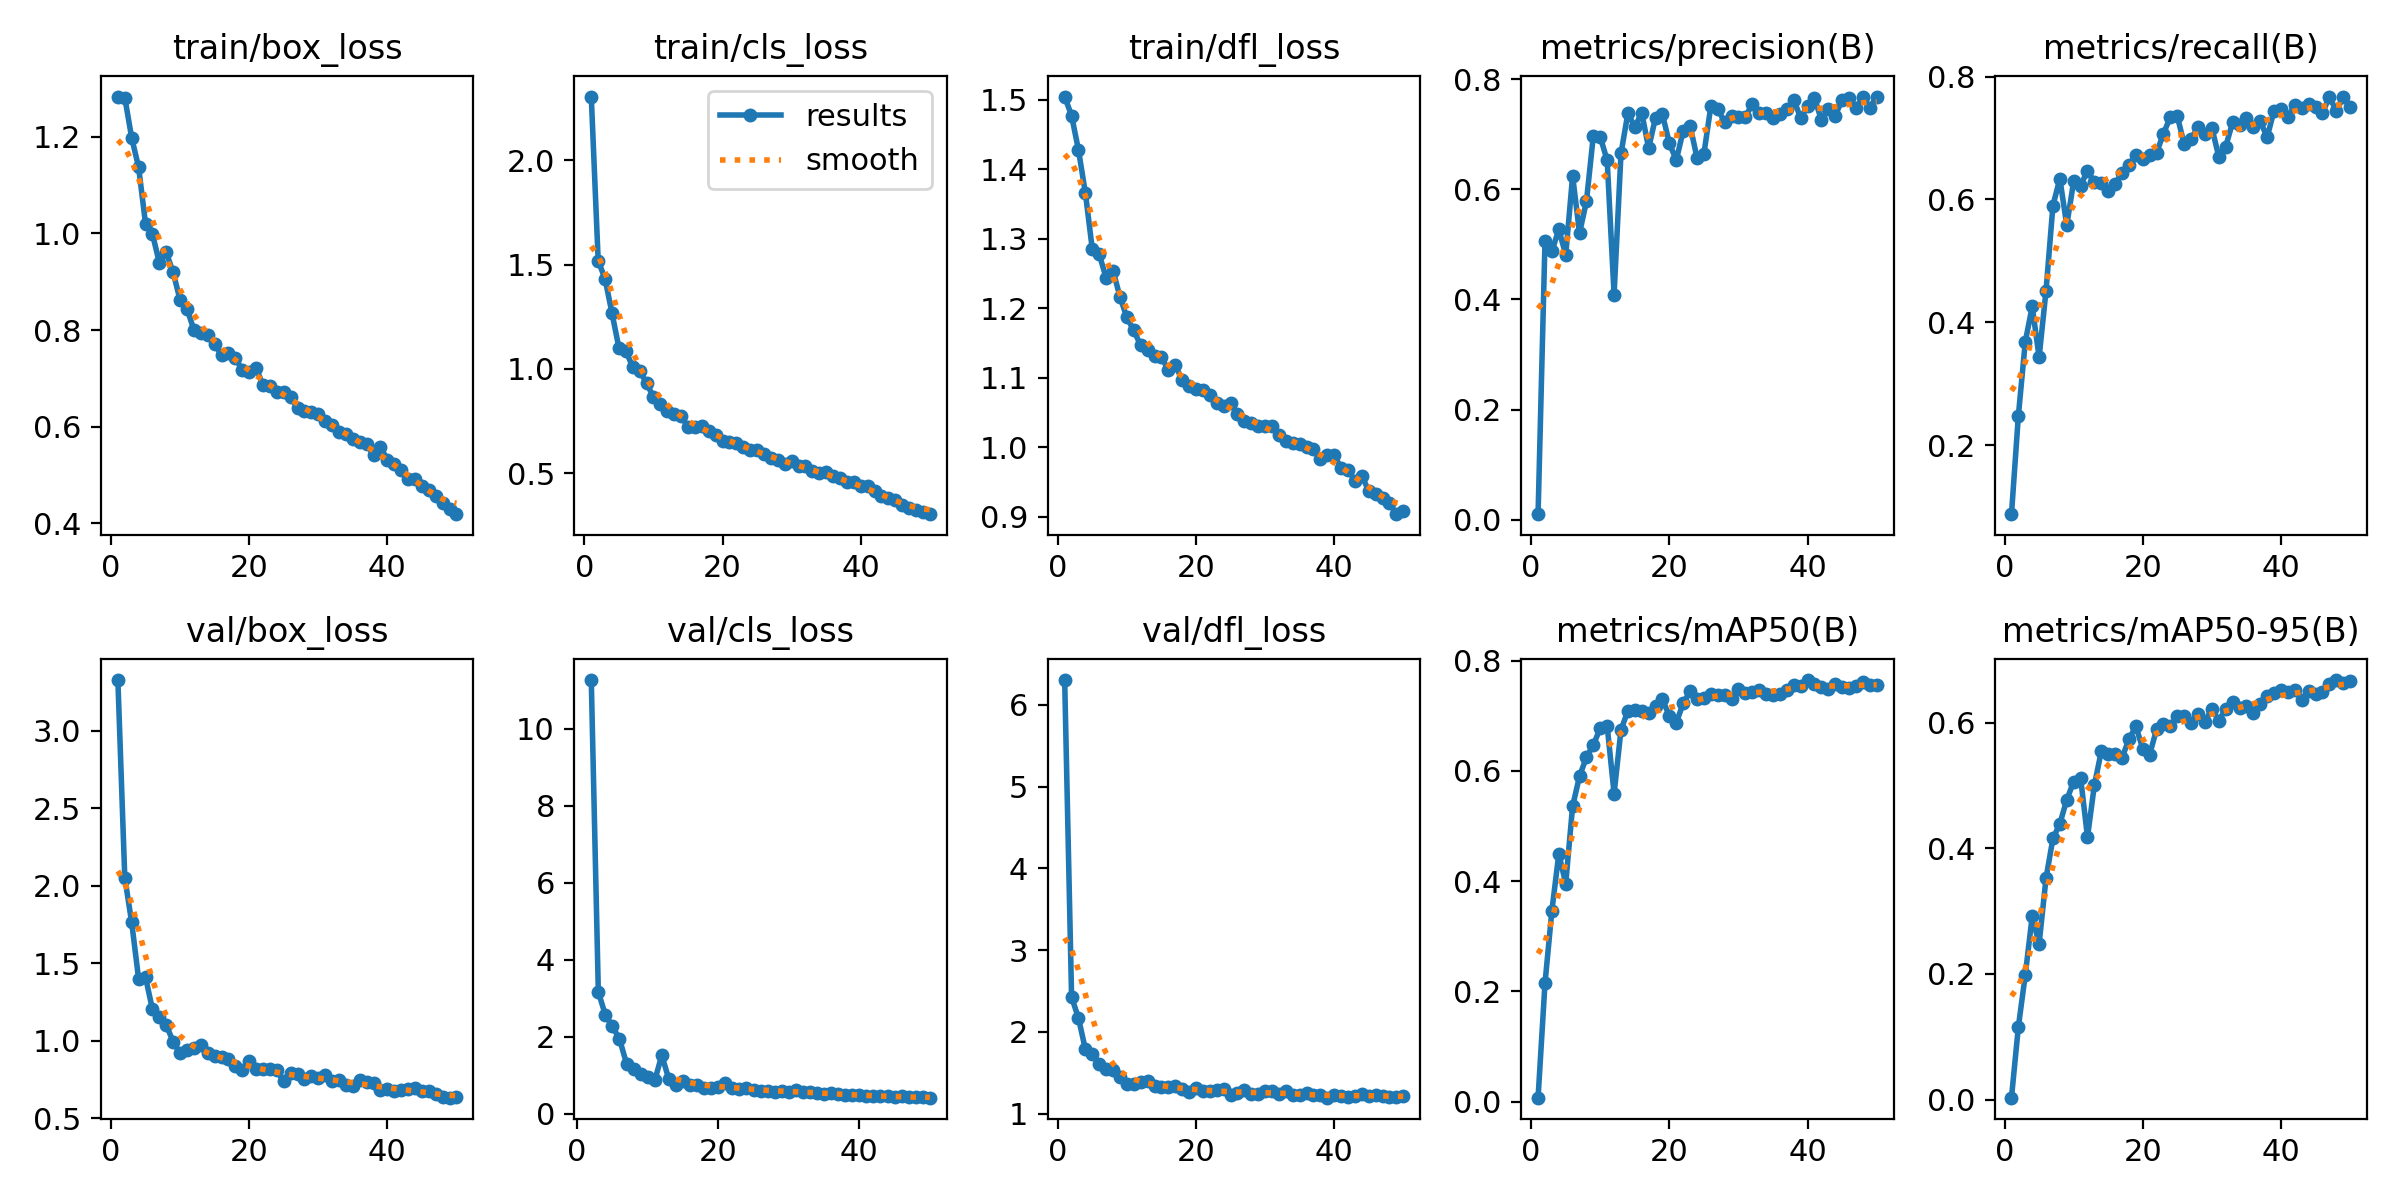


Precision-Recall 곡선 (BoxPR_curve.png):


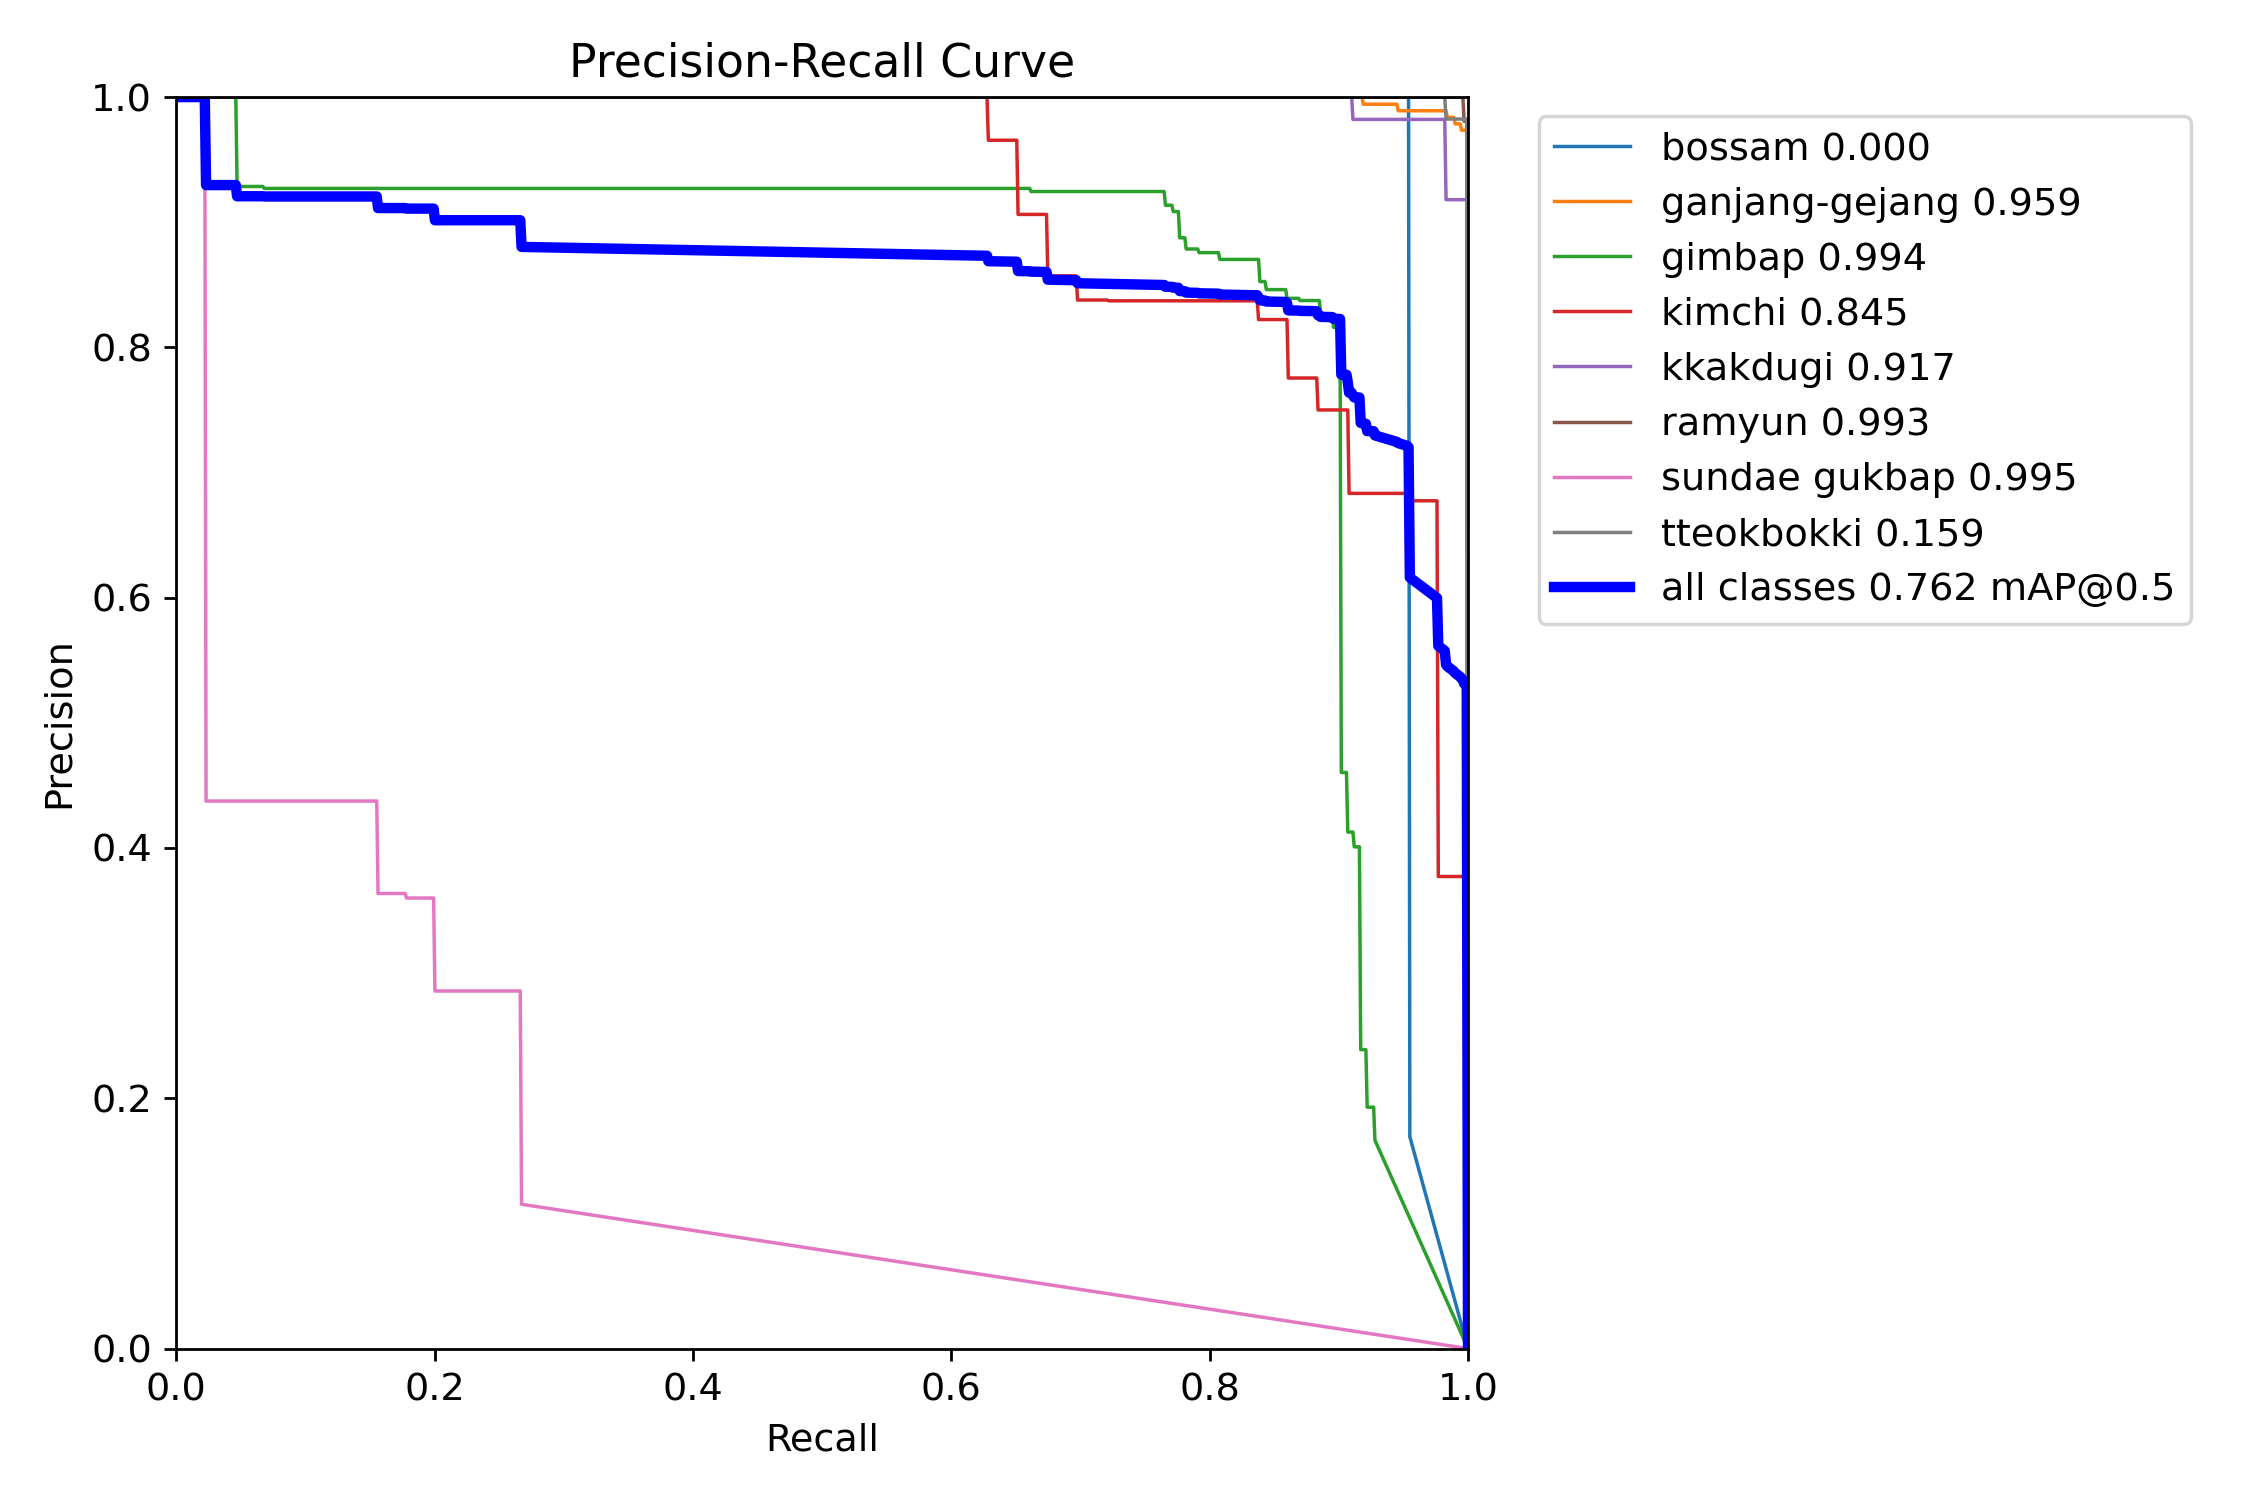

In [ ]:
from IPython.display import Image, display
import os

# Define the path to the training results directory
results_dir = 'food_detection/exp'

# Display the results.png which summarizes training performance
results_image_path = os.path.join(results_dir, 'results.png')
if os.path.exists(results_image_path):
    print("학습 결과 요약 (results.png):")
    display(Image(filename=results_image_path))
else:
    print(f"'{results_image_path}' 파일을 찾을 수 없습니다.")

# Display the PR curve (Precision-Recall curve)
pr_curve_path = os.path.join(results_dir, 'BoxPR_curve.png')
if os.path.exists(pr_curve_path):
    print("\nPrecision-Recall 곡선 (BoxPR_curve.png):")
    display(Image(filename=pr_curve_path))
else:
    print(f"'{pr_curve_path}' 파일을 찾을 수 없습니다. (BoxPR_curve.png)")


**4 .YOLO 추론 결과와 영양 정보 매핑**

<aside>

**진행 프로세스**

- **테스트 세트 성능 평가:** 학습된 `best.pt` 모델을 불러와 테스트 세트로 성능을 검증합니다.
    - mAP50, mAP50-95, Precision, Recall 값을 출력하여 모델의 전반적인 성능 확인
- 테스트 이미지 한 장을 입력하여 **이미지 추론 실행을 실행하며,  칼로리 정보를 연동하여** 모델이 예측한 클래스 ID를 이용해 해당 음식의 칼로리 정보를 조회하고 출력합니다.
    - 예측된 결과는 시각화하여 확인하고, 탐지된 음식 객체의 위치와 클래스 정보 출력
    - `food_calories.json` 파일에서 음식 클래스에 해당하는 칼로리 값 출력
</aside>

✅ 'best.pt' 모델 로드 완료.

테스트 세트 성능 평가:
Ultralytics 8.3.209 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1446.5±953.9 MB/s, size: 146.0 KB)
val: Scanning /content/Food/test/labels.cache... 258 images, 3 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 258/258 370.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.1it/s 5.5s
                   all        258        423      0.849      0.791      0.857       0.75
                bossam          1          2          0          0          0          0
        ganjang-gejang         13         13      0.947          1      0.995      0.942
                gimbap         25        112          1      0.836      0.988      0.862
                kimchi         79        100      0.795      0.815       0.81      0.526
            

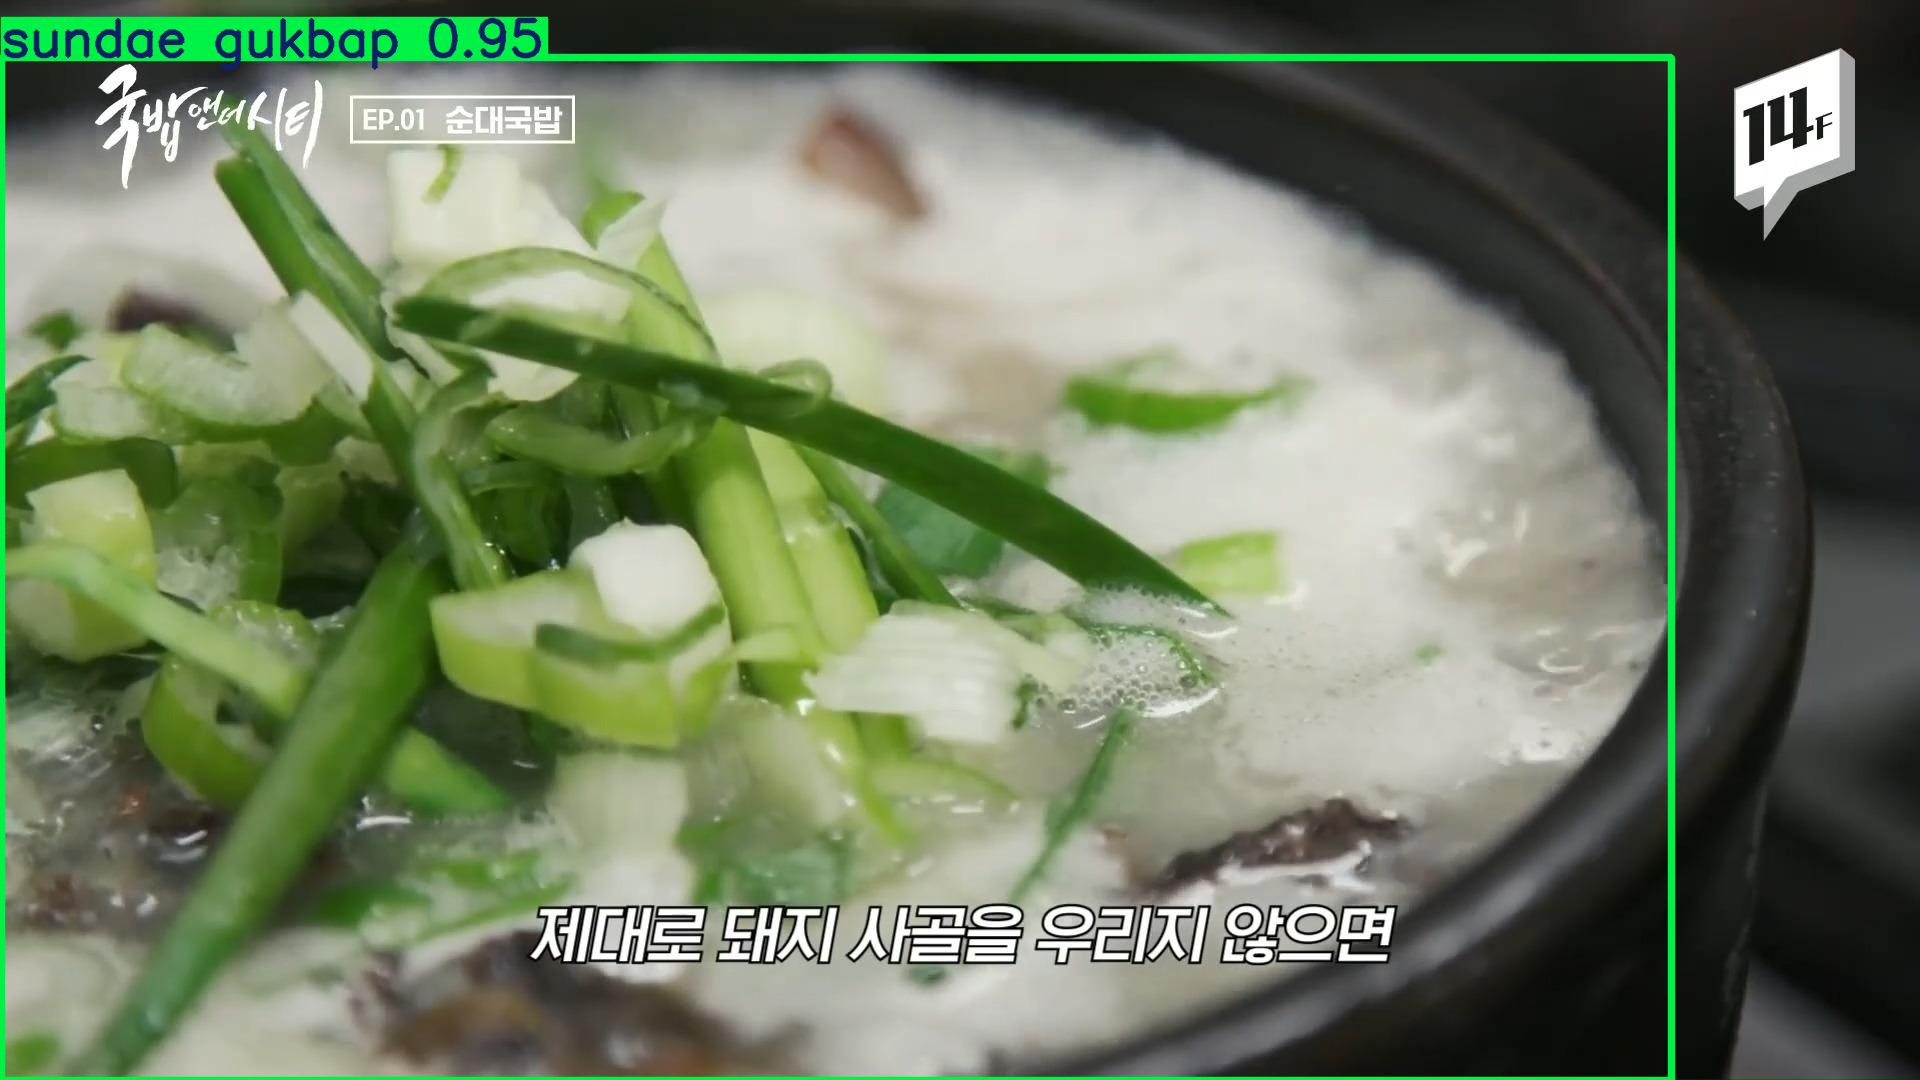

In [ ]:
from ultralytics import YOLO
import json
import os
import cv2
from google.colab.patches import cv2_imshow # Colab에서 이미지 출력을 위해 사용

# 1. 학습된 best 모델 불러오기
try:
    best_model = YOLO("food_detection/exp/weights/best.pt")
    print("✅ 'best.pt' 모델 로드 완료.")
except Exception as e:
    print(f"❌ 'best.pt' 모델 로드 중 오류 발생: {e}")
    print("모델 학습이 완료되지 않았거나 'food_detection/exp/weights/best.pt' 파일이 존재하지 않습니다.")
    best_model = None # 모델 로드 실패 시 이후 코드 실행 방지


if best_model:
    # 2. 테스트 세트 성능 평가 (이전 학습 단계에서 이미 수행되었을 수 있지만, 다시 확인)
    print("\n테스트 세트 성능 평가:")
    try:
        metrics = best_model.val(data="/content/Food/data.yaml", split="test")
        print("mAP50:", metrics.box.map50)
        print("mAP50-95:", metrics.box.map)
        print("Precision:", metrics.box.mp)
        print("Recall:", metrics.box.mr)
    except Exception as e:
        print(f"❌ 테스트 세트 성능 평가 중 오류 발생: {e}")


    # 3. 테스트 이미지 한 장으로 추론 실행
    test_image_folder = "/content/Food/test/images"
    image_files = [f for f in os.listdir(test_image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"\n❌ 테스트 이미지 폴더 '{test_image_folder}'에 이미지 파일이 없습니다.")
    else:
        # 첫 번째 이미지 파일을 선택하여 추론
        test_image_file = image_files[0]
        test_image_path = os.path.join(test_image_folder, test_image_file)
        print(f"\n이미지 추론 실행: {test_image_file}")

        try:
            # 추론 수행
            results = best_model(test_image_path)

            # 4. 칼로리 정보 로드
            calorie_file_path = '/content/food_calories.json'
            food_calories = {}
            if os.path.exists(calorie_file_path):
                with open(calorie_file_path, 'r', encoding='utf-8') as f:
                    # JSON 구조가 리스트인지 딕셔너리인지 확인하고 로드
                    calorie_data = json.load(f)
                    if isinstance(calorie_data, list):
                        # 리스트 형태의 JSON인 경우 딕셔너리로 변환 (음식 이름으로 조회하기 쉽게)
                        food_calories = {item["food_name"]: item["calories"] for item in calorie_data}
                    elif isinstance(calorie_data, dict):
                        food_calories = calorie_data
                    else:
                        print(f"❌ '{calorie_file_path}' 파일의 JSON 형식이 예상과 다릅니다.")
            else:
                print(f"❌ 음식 칼로리 정보 파일 '{calorie_file_path}'을(를) 찾을 수 없습니다.")


            # 5. 추론 결과 분석 및 칼로리 정보 매핑
            print("\n--- 감지된 음식 객체 및 칼로리 정보 ---")
            detected_foods_info = []
            if results and results[0].boxes: # 결과가 있고 감지된 객체가 있는지 확인
                for r in results:
                    for i in range(len(r.boxes)):
                        cls = int(r.boxes.cls[i])
                        conf = float(r.boxes.conf[i])
                        box = r.boxes.xyxy[i].cpu().numpy().tolist() # 바운딩 박스 좌표

                        # 클래스 ID를 클래스 이름으로 변환
                        class_name = best_model.names[cls] if cls in best_model.names else f"Unknown_{cls}"

                        # 칼로리 정보 조회
                        calories = food_calories.get(class_name, "정보 없음")

                        print(f"- 음식: {class_name}, 신뢰도: {conf:.2f}, 칼로리: {calories}")
                        detected_foods_info.append({
                            "name": class_name,
                            "confidence": conf,
                            "bbox": box,
                            "calories": calories
                        })

                # 6. 시각화 결과 출력 (Colab 환경에 맞게 cv2_imshow 사용)
                print("\n--- 추론 시각화 결과 ---")
                # YOLOv8의 plot 함수를 사용하여 결과 이미지 생성
                img_annotated = results[0].plot() # plot 함수가 넘파이 배열을 반환

                # OpenCV 형식 (BGR)에서 matplotlib 형식 (RGB)으로 변환 (cv2_imshow는 BGR 사용)
                # img_annotated_bgr = cv2.cvtColor(img_annotated, cv2.COLOR_RGB2BGR) # plot 함수 결과가 이미 BGR일 수도 있음, 확인 필요

                cv2_imshow(img_annotated)


            else:
                print("감지된 음식 객체가 없습니다.")

        except Exception as e:
            print(f"❌ 이미지 추론 및 분석 중 오류 발생: {e}")

5. **동영상 추론 & 영양정보 매핑**

<aside>

**진행 프로세스**

- 다음 코드를 이용하여 유튜브 영상자료를 다운로드합니다.
    - 유튜브 영상자료 다운로드 코드
    유튜브 url은 예이며 직접 모델 제작 source데이터셋 확인하여 선택하여 봅니다
        
        ```
        # YouTube 영상다운로드
        # 1. 필요한 패키지 설치
        !pip install yt-dlp
        
        # 2. YouTube 영상 다운로드
        video_url="https://www.youtube.com/watch?v=tCxH2zS5tCw"
        
        # 영상 다운로드 (전체 또는 일부)
        !yt-dlp -f "best[height<=720]" -o "food.mp4" {video_url}
        # 처음 30초만 다운로드하려면:
        # !yt-dlp -f "best[height<=720]" --download-sections "*0-30" -o "food_video.mp4" {video_url}
        
        print("영상 다운로드 완료")
        ```
        
- 영상의 일부분만 테스트 한후 (3초정도), 동영상의 추론정보, 칼로리정보를 매핑한 데이터를 작성한뒤 영상자료에 대한 기초통계와 시각화로 추론결과를 분석합니다.
    - save_txt=True 옵션을 통하여 각 프레임별로의 영상 추출 기록을 저장
        - 코드 참조
            
            ```
            import cv2
            from ultralytics import YOLO
            
            # 1. YOLO 모델 불러오기
            model = YOLO("food_detection/exp/weights/best.pt")
            
            # 2. 원본 영상 열기
            video_path = "/content/food.mp4"
            cap = cv2.VideoCapture(video_path)
            
            fps = int(cap.get(cv2.CAP_PROP_FPS))
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            
            # 3. 앞 3분만 잘라서 새 영상 저장
            clip_path = "/content/food_clip_3min.mp4"
            out = cv2.VideoWriter(clip_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
            
            max_frames = fps * 180   # 3분(180초)
            frame_count = 0
            
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret or frame_count >= max_frames:
                    break
                out.write(frame)
                frame_count += 1
            
            cap.release()
            out.release()
            print(f"🎬 앞 3분(총 {frame_count}프레임) 저장 완료: {clip_path}")
            
            # 4. YOLO 추론 (앞 3분 영상만)
            results = model.predict(
                source=clip_path,
                conf=0.5,
                save=True,    # 결과 영상 저장
                show=False,
                stream=False,
                save_txt=True
            )
            
            print(f"\n✅ 총 {frame_count}프레임(3분) 분석 완료!")
            print("📁 결과 영상은 runs/detect/predict/ 에 저장됩니다.")
            
            ```
            
    - 추론결과의 label폴더에 있는 결과물.txt의 모든 취합, 기초통계
- 동영상 데이터는 초당 수십 장의 프레임으로 구성되며, 객체 인식 모델은 이를 개별 이미지로 분석합니다. 그러나 모든 프레임을 직접 분석하면 데이터가 과도하게 세분화되어 전체적인 흐름을 파악하기 어렵습니다. 따라서 1초단위 이동 평균을 적용해 변동성을 줄이고, 음식 등장 패턴을 보다 명확하게 시각화합니다.
    - 매 프레임마다 검출된 음식 객체의 개수를 라인차트로 시각화
    - food.mp4의 FPS로 계산한 음식 객체 수의 이동 평균을 라인차트로 시각화
</aside>

In [ ]:
# YouTube 영상다운로드
# 1. 필요한 패키지 설치
!pip install yt-dlp

# 2. YouTube 영상 다운로드
video_url="https://www.youtube.com/watch?v=tCxH2zS5tCw"

# 영상 다운로드 (전체 또는 일부)
# 수정: 영상 포맷 지정 옵션 제거, 파일명만 지정
!yt-dlp -o "food.mp4" {video_url}
# 처음 30초만 다운로드하려면: (이전 코드 유지)
# !yt-dlp "best[height<=720]" -S "+size,+br" --recode-video mp4 --download-sections "*0-30" -o "food_video.mp4" {video_url}

#cookie 로그인 에러로 인해 로컬에서 다운로드 후 파일 옮겨서 진행

print("영상 다운로드 완료")

[youtube] Extracting URL: https://www.youtube.com/watch?v=tCxH2zS5tCw
[youtube] tCxH2zS5tCw: Downloading webpage
[youtube] tCxH2zS5tCw: Downloading tv client config
[youtube] tCxH2zS5tCw: Downloading tv player API JSON
[youtube] tCxH2zS5tCw: Downloading web safari player API JSON
ERROR: [youtube] tCxH2zS5tCw: Sign in to confirm you’re not a bot. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
영상 다운로드 완료


In [ ]:
import cv2
from ultralytics import YOLO

# 1. YOLO 모델 불러오기
model = YOLO("food_detection/exp/weights/best.pt")

# 2. 원본 영상 열기
video_path = "/content/food.mp4"
cap = cv2.VideoCapture(video_path)

fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# 3. 앞 3분만 잘라서 새 영상 저장
clip_path = "/content/food_clip_3min.mp4"
out = cv2.VideoWriter(clip_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

max_frames = fps * 180   # 3분(180초)
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame_count >= max_frames:
        break
    out.write(frame)
    frame_count += 1

cap.release()
out.release()
print(f"🎬 앞 3분(총 {frame_count}프레임) 저장 완료: {clip_path}")

# 4. YOLO 추론 (앞 3분 영상만)
results = model.predict(
    source=clip_path,
    conf=0.5,
    save=True,    # 결과 영상 저장
    show=False,
    stream=False,
    save_txt=True
)

print(f"\n✅ 총 {frame_count}프레임(3분) 분석 완료!")
print("📁 결과 영상은 runs/detect/predict/ 에 저장됩니다.")

🎬 앞 3분(총 2986프레임) 저장 완료: /content/food_clip_3min.mp4

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/2986) /content/food_clip_3min.mp4: 384x640 (no detections), 11.6ms
video 1/1 (frame 2/2986) /content/food_clip_3min.mp4: 384x640 (no detections), 10.7ms
video 1/1 (frame 3/2986) /content/food_clip_3min.mp4: 384x640 (no detections), 10.9ms
video 1/1 (frame 4/2986) /content/food_clip_3min.mp4: 384x640 (no detections), 10.7ms
video 1/1 (frame 5/2986) /content/food_clip_3min.mp4: 384x6

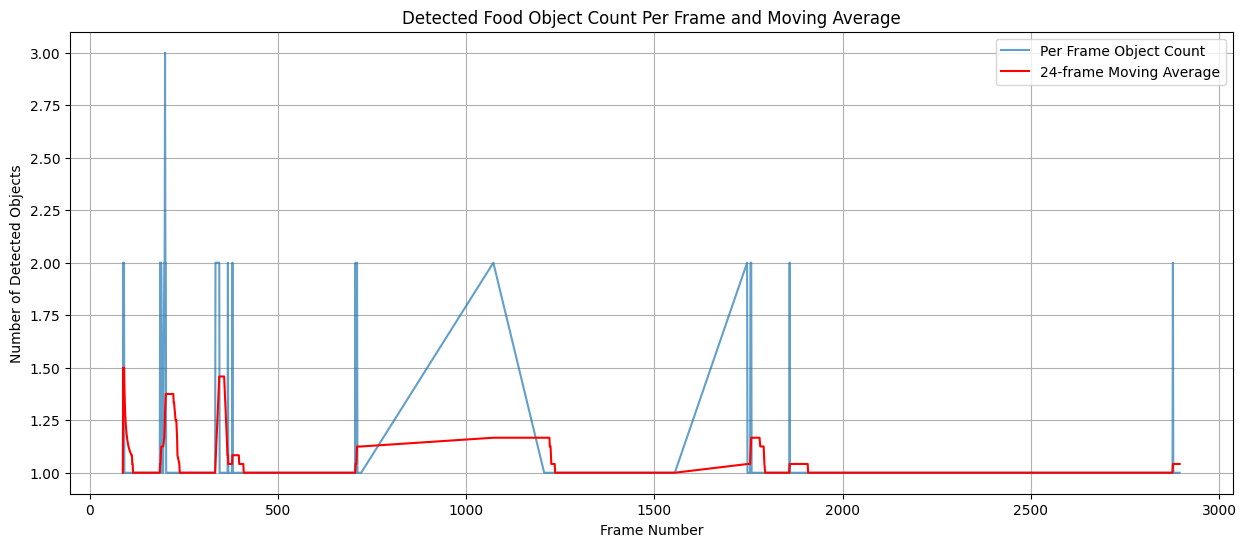


✅ 객체 감지 수 및 이동 평균 시각화 완료.


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2 # to get video FPS

# Define the path to the directory containing the prediction labels
labels_dir = 'runs/detect/predict/labels'

# Get list of all label files
label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
# Modify sorting key to handle filenames like food_clip_3min_XXXX.txt
try:
    label_files.sort(key=lambda x: int(os.path.splitext(x)[0].split('_')[-1])) # Sort files by frame number extracted from the end
except ValueError as e:
    print(f"Error processing filename for sorting: {e}")
    print("Please check the filenames in the labels directory:")
    for f in label_files:
        print(f)
    # Fallback to original sorting or handle error as needed
    label_files.sort(key=lambda x: os.path.splitext(x)[0]) # Fallback to alphabetical sort

# Dictionary to store object counts per frame
frame_object_counts = {}

# Process each label file
for label_file in label_files:
    # Extract frame number - adjusted to handle potential prefixes
    try:
        frame_number_str = os.path.splitext(label_file)[0].split('_')[-1]
        frame_number = int(frame_number_str)
    except ValueError:
        print(f"Skipping file with invalid frame number format: {label_file}")
        continue # Skip files that don't match the expected format

    file_path = os.path.join(labels_dir, label_file)

    # Count objects in the label file (each line represents a detected object)
    with open(file_path, 'r') as f:
        object_count = len(f.readlines())

    frame_object_counts[frame_number] = object_count

# Convert to a pandas Series for easier plotting and moving average calculation
# Ensure frame numbers are sorted as index for correct plotting and moving average
frame_counts_series = pd.Series(frame_object_counts).sort_index()


# Get FPS of the video to calculate moving average window
video_path = "/content/food_clip_3min.mp4" # Use the clipped video path
cap = cv2.VideoCapture(video_path)
if cap.isOpened():
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    cap.release()
else:
    print(f"Warning: Could not open video file {video_path} to get FPS. Using a default window size of 30 for moving average.")
    fps = 30 # Default FPS if video cannot be opened

# Calculate moving average (window size = FPS for 1 second moving average)
moving_average_window = fps
frame_counts_series_ma = frame_counts_series.rolling(window=moving_average_window, min_periods=1).mean()


# Plotting
plt.figure(figsize=(15, 6))

# Plot raw frame object counts
plt.plot(frame_counts_series.index, frame_counts_series.values, label='Per Frame Object Count', alpha=0.7)

# Plot moving average
plt.plot(frame_counts_series_ma.index, frame_counts_series_ma.values, label=f'{moving_average_window}-frame Moving Average', color='red')

plt.title('Detected Food Object Count Per Frame and Moving Average')
plt.xlabel('Frame Number')
plt.ylabel('Number of Detected Objects')
plt.legend()
plt.grid(True)
plt.show()

print("\n✅ 객체 감지 수 및 이동 평균 시각화 완료.")

6. **프레임 단위 추론 결과를 활용한 클래스별 이미지 정리**

<aside>

**진행 프로세스**

- 음식 이름별로 이미지를 정리해두면 객체 인식·분류 모델의 학습용 데이터셋으로 직접 활용할 수 있으며, 클래스별 데이터 분포를 비교해 불균형을 확인하고 추가 수집이나 보강이 필요한 대상을 쉽게 파악할 수 있습니다. 또한 이렇게 저장된 프레임 이미지는 칼로리 추정, 식사 패턴 분석, 리포트 생성 등 다양한 후속 분석과 응용으로 확장할 수 있습니다.
    - 데이터를 활용해 음식 이름별로 등장하는 프레임을 탐색하고, 해당 프레임 이미지를 추출하여 음식 이름 폴더에 자동 저장
    - 프레임 번호를 실제 시‧분‧초로 변환하여 음식별 폴더에 저장된 이미지 파일명을 일관된 형식으로 정리
- 최종 출력물을 이용한 활용방안 아이디어를 도출합니다.
</aside>

In [ ]:
import os
import cv2
import pandas as pd
import math

# Define paths
video_path = "/content/food_clip_3min.mp4" # Use the clipped video path
labels_dir = 'runs/detect/predict/labels'
output_base_dir = 'food_frames_by_class'

# Ensure output base directory exists
os.makedirs(output_base_dir, exist_ok=True)

# Load the video to get FPS
cap = cv2.VideoCapture(video_path)
if cap.isOpened():
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    cap.release()
else:
    print(f"Error: Could not open video file {video_path}")
    fps = 30 # Default FPS if video cannot be opened


# Dictionary to store detected objects per frame with class info
frame_detections = {}

# Process each label file
label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
# Modify sorting key to handle filenames like food_clip_3min_XXXX.txt
try:
    label_files.sort(key=lambda x: int(os.path.splitext(x)[0].split('_')[-1])) # Sort files by frame number extracted from the end
except ValueError as e:
    print(f"Error processing filename for sorting: {e}")
    print("Please check the filenames in the labels directory:")
    for f in label_files:
        print(f)
    # Fallback to original sorting or handle error as needed
    label_files.sort(key=lambda x: os.path.splitext(x)[0]) # Fallback to alphabetical sort


# Assuming you have access to the class names from the data.yaml or trained model
# If not, you might need to load them. For now, using placeholder names
# Replace with actual class names from your model or data.yaml
class_names = {
    0: "김치찌개", 1: "불고기", 2: "비빔밥", 3: "갈비찜", 4: "삼겹살",
    5: "잡채", 6: "해물파전", 7: "김밥", 8: "떡볶이", 9: "순두부찌개", 10: "된장찌개"
}


for label_file in label_files:
    # Extract frame number - adjusted to handle potential prefixes
    try:
        frame_number_str = os.path.splitext(label_file)[0].split('_')[-1]
        frame_number = int(frame_number_str)
    except ValueError:
        print(f"Skipping file with invalid frame number format: {label_file}")
        continue # Skip files that don't match the expected format

    file_path = os.path.join(labels_dir, label_file)

    detections = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) > 0:
                class_id = int(parts[0])
                class_name = class_names.get(class_id, f"unknown_class_{class_id}")
                detections.append({"class_id": class_id, "class_name": class_name})

    if detections:
        frame_detections[frame_number] = detections

print(f"Processed {len(frame_detections)} frames with detections.")

# Open the video again to extract frames
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Error: Could not open video file {video_path} for frame extraction.")
else:
    print("\nExtracting and saving frames by class...")
    for frame_number, detections in frame_detections.items():
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if ret:
            # Calculate timestamp
            seconds = frame_number / fps
            minutes = math.floor(seconds / 60)
            seconds = math.floor(seconds % 60)
            timestamp = f"{minutes:02d}_{seconds:02d}" # MM_SS format

            for detection in detections:
                class_name = detection["class_name"]

                # Create a directory for the class if it doesn't exist
                class_output_dir = os.path.join(output_base_dir, class_name)
                os.makedirs(class_output_dir, exist_ok=True)

                # Define the output filename
                output_filename = f"frame_{frame_number}_{timestamp}.jpg"
                output_path = os.path.join(class_output_dir, output_filename)

                # Save the frame
                cv2.imwrite(output_path, frame)

    cap.release()
    print("✅ 프레임 추출 및 클래스별 저장 완료.")
    print(f"결과는 '{output_base_dir}' 폴더에 저장되었습니다.")

# Final step: Ideate on utilization methods (as requested)
print("\n--- 최종 출력물을 이용한 활용 방안 아이디어 ---")
print("1. **객체 인식/분류 모델 학습 데이터셋**: 클래스별로 정리된 이미지를 활용하여 특정 음식에 특화된 모델을 추가 학습하거나 미분류된 객체를 분류하는 데 사용.")
print("2. **데이터셋 불균형 분석**: 각 음식 폴더의 이미지 개수를 비교하여 데이터셋의 클래스별 분포를 확인하고, 부족한 클래스의 이미지 보강 계획 수립.")
print("3. **식사 패턴 및 영양 분석**: 특정 시간대나 영상 구간에서 자주 등장하는 음식을 파악하고, 칼로리 정보를 연동하여 식사 기록 및 영양 섭취 분석에 활용.")
print("4. **맞춤형 추천 시스템**: 사용자의 식사 기록(감지된 음식)을 기반으로 맞춤형 레시피나 영양 정보를 추천하는 시스템 개발.")
print("5. **보고서 자동 생성**: 특정 기간 동안 감지된 음식 종류, 빈도, 예상 칼로리 등을 포함하는 자동 보고서 생성 시스템 구축.")
print("6. **품질 관리 및 이상 감지**: 제조 공정 영상 분석 시, 특정 객체(제품, 장비)의 등장 빈도나 상태 변화를 추적하여 생산 라인 효율성 및 이상 징후 감지에 활용.")

Processed 667 frames with detections.

Extracting and saving frames by class...
✅ 프레임 추출 및 클래스별 저장 완료.
결과는 'food_frames_by_class' 폴더에 저장되었습니다.

--- 최종 출력물을 이용한 활용 방안 아이디어 ---
1. **객체 인식/분류 모델 학습 데이터셋**: 클래스별로 정리된 이미지를 활용하여 특정 음식에 특화된 모델을 추가 학습하거나 미분류된 객체를 분류하는 데 사용.
2. **데이터셋 불균형 분석**: 각 음식 폴더의 이미지 개수를 비교하여 데이터셋의 클래스별 분포를 확인하고, 부족한 클래스의 이미지 보강 계획 수립.
3. **식사 패턴 및 영양 분석**: 특정 시간대나 영상 구간에서 자주 등장하는 음식을 파악하고, 칼로리 정보를 연동하여 식사 기록 및 영양 섭취 분석에 활용.
4. **맞춤형 추천 시스템**: 사용자의 식사 기록(감지된 음식)을 기반으로 맞춤형 레시피나 영양 정보를 추천하는 시스템 개발.
5. **보고서 자동 생성**: 특정 기간 동안 감지된 음식 종류, 빈도, 예상 칼로리 등을 포함하는 자동 보고서 생성 시스템 구축.
6. **품질 관리 및 이상 감지**: 제조 공정 영상 분석 시, 특정 객체(제품, 장비)의 등장 빈도나 상태 변화를 추적하여 생산 라인 효율성 및 이상 징후 감지에 활용.
